# Algorithms 202: Coursework 2 Task 1: Random Sampling

Group-ID: 23

Group members: Balint Rikker, Peng Peng, John Oliver

## Objectives

The aim of this coursework is to enhance your algorithmic skills by developing algorithms from textual, non-formal descriptions. You are asked to show that you can:

- implement three different random sampling algorithms
- compare those algorithms using visual representations based on image sampling

This notebook *is* the coursework. It contains cells with function definitions that you will need to complete. You will submit this notebook as your coursework.

## Preliminaries: helper functions

Here we define a collection of functions that will be useful for the rest of the coursework. You'll need to run this cell to get started.

In [3]:
%matplotlib inline
import numpy as np
import math
from scipy.ndimage import map_coordinates
from scipy.spatial import cKDTree as KDTree
from matplotlib import pyplot as plt
from PIL import Image


def load_image(path):
    return np.array(Image.open(str(path)))

def sample_colors(image, sample_points):
    r"""
    Sample RGB colour values from an image of shape (w, h, 3)
    at floating point (x, y) sample points.
    """
    r = map_coordinates(image[..., 0], sample_points.T)
    g = map_coordinates(image[..., 1], sample_points.T)
    b = map_coordinates(image[..., 2], sample_points.T)
    return np.vstack((r, g, b)).T

def indices_of_pixels(image):
    r"""(x, y) index values for each pixel in an image.
    """
    return np.indices(image.shape[:2]).reshape([2, -1]).T

def closest_index(sample_points, indices):
    r"""
    Find the nearest sample_point at a given index
    (along with the distance to the point). Input is
    an array of sample_points and an array of indicies to
    test at. Output is array of indices and distances.
    """
    kdtree = KDTree(sample_points)
    distance, index = kdtree.query(indices)
    return index, distance

def resample_image(image, sample_points):
    # for each (floating point) sample_point extract the
    # RGB colour value of the image at that location
    colors = sample_colors(image, sample_points)
    # get all (x, y) index values for each pixel in
    # the image
    indices = indices_of_pixels(image)
    # for every pixel (each index) find the nearest sample
    # point (and the distance, but we don't need it here)
    c_index,_ = closest_index(sample_points, indices)
    # map the closest indexes to colour values - reshape
    # the resulting RGB array back into the original image 
    # shape.
    return colors[c_index].reshape(image.shape)

## Task 1: Random Sampling

In this task you are asked to implement `uniform_sampling`, `best_candidate_sampling` and `poison_disc_sampling`. Additionally, you will need to implement visualising techniques that can be used to compare the output of the three different random sampling algorithms.

Complete the below function definitions in the provided skeleton code. Do not change the names of the functions or their arguments.

### 1a. Implement `uniform_sampling`

The `uniform_sampling` function should produce `n_samples` sample points randomly distributed over the sample domain. See lecture slides for details and pseudo-code. Hint: The sample domain defined by the width and the height of the image can be obtained by `image.shape[:2]`.

In [4]:
import random

# complete function without changing signature
def uniform_sampling(image, n_samples):
    l = []
    height, width = image.shape[:2]
    for i in range(n_samples):
        x = int(random.uniform(0, height))
        y = int(random.uniform(0, width))
        l.append([x, y])       
    return np.array(l)

### 1b. Implement `best_candidate_sampling`

The `best_candidate_sampling` function should produce `n_samples` sample points randomly distributed over the sample domain. See lecture slides for details and pseudo-code. Hint: The `best_candidate` function here corresponds to the BEST-CANDIDATE-SAMPLE function in the slides, which generates a single new sample.

In [5]:
def best_candidate_sampling(image, n_samples, n_candidates):
    l = uniform_sampling(image, 1).tolist()
    for i in range(n_samples - 1):
        s = best_candidate(image, l, n_candidates)
        l.append(s)
    return np.array(l)

def best_candidate(image, samples, n_candidates):
    height, width = image.shape[:2]
    best_cand = [0, 0]
    best_dist = 0
    # generate n_candidates uniform-samples
    l = uniform_sampling(image, n_candidates).tolist()
    for c in l:
        d = distance(find_closest(samples, c), c)
        if (d > best_dist):
            best_dist = d
            best_cand = c
    return best_cand

def find_closest(samples, c):
    closest_d = float("inf")
    closest_c = samples[0]
    for s in samples:
        d = distance(s, c)
        if (d < closest_d):
            closest_d = d
            closest_c = s
    return closest_c
        
def distance(p1, p2):
    x1, x2 = p1[:2]
    y1, y2 = p2[:2]
    return math.sqrt(math.pow((x1 - y1), 2) + 
                     math.pow((x2 - y2), 2))

### 1c. Implement `poison_disc_sampling`

The `poison_disc_sampling` function should produce sample points randomly distributed over the sample domain with a minimum distance of `radius`. See lecture slides and [Bridson's original paper](https://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf) for details.

In [6]:
def poison_disc_sampling(image, radius, n_candidates):
    height, width = image.shape[:2]
    
    # initialize 2-dimensional grid for storing samples
    # cell size bounded by r/sqrt(2), because we are in 2D
    cell_size = radius / math.sqrt(2)
    grid_h = math.ceil(height / cell_size)
    grid_w = math.ceil(width / cell_size)
    
    # None indicates no sample
    grid = [[None for j in range(grid_w)] for i in range(grid_h)]
    
    active_list   = []
    sample_points = []
    
    # select initial sample uniformly, insert into active list, insert index to grid
    first_s = (random.random() * height, random.random() * width)
    active_list.append(first_s)
    sample_points.append(first_s)
    grid[grid_dim(first_s[0], cell_size)][grid_dim(first_s[1], cell_size)] = first_s
    
    while (active_list):
        # pop random element
        origin = active_list.pop(random.randrange(len(active_list)))
        # generate n_candidates samples uniformly between radius and 2-radius
        for i in range(n_candidates):
            s = new_sample(origin, radius)
            # check if it is within distance radius of existing samples
            if in_image(image, s) and not in_neighbourhood(grid, active_list, s, radius, cell_size):
                active_list.append(s)
                sample_points.append(s)
                grid[grid_dim(s[0], cell_size)][grid_dim(s[1], cell_size)] = s
    return np.array(sample_points)

# translate sample paramater given image space to grid space
def grid_dim(param, cell_size):
    return int(param / cell_size)

# returns point in between radius and 2-radius distance from the origin uniformly
def new_sample(centre, radius):
    radius2 = 2 * radius
    theta   = random.uniform(0, 2 * math.pi)
    norm_c  = 2 / (radius2 * radius2 - radius * radius) # normalising constant for uniform distribution
    r = math.sqrt(2 * random.uniform(0, 1) / norm_c + radius * radius)
    o_x, o_y = centre[:2]
    x = o_x + r * math.cos(theta)
    y = o_y + r * math.sin(theta)
    return [x, y]

# returns true iff generated sample is in the boundaries of the image
def in_image(image, sample):
    height, width = image.shape[:2]
    x, y = sample[:2]
    return (0 <= x and x <= height and 0 <= y and y <= width)
           
# check if sample is within distance radius of existing samples
# use the background grid, so we only need to check the nearby samples
def in_neighbourhood(grid, active_list, sample, radius, cell_size):
    x, y = sample[:2]
    g_x  = grid_dim(x, cell_size)
    g_y  = grid_dim(y, cell_size)
    # if we draw circles with radius `radius' around the corners of the given grid cell, we find, that there
    # are 21 cells that potentially contain offending samples. 
    # To simplify the algorithm we can check the complete 5x5 square around the cell.
    for i in range(g_x - 2, g_x + 2 + 1):
        for j in range(g_y - 2, g_y + 2 + 1):
            if (in_grid(grid, i, j) and grid[i][j] is not None):
                cand = grid[i][j]
                if distance(sample, cand) < radius:
                    return True
    return False

def in_grid(grid, x, y):
    height = len(grid)
    width  = len(grid[0])
    return (0 <= x and x < height and 0 <= y and y < width)

### Image sampling

The following cells are for testing and visualisation of your sampling methods.

#### Load test image

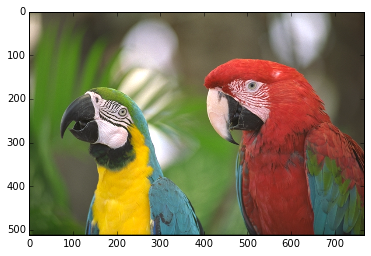

In [7]:
#image= load_image('./brain.png')
#image = load_image('./face.png')
#image = load_image('./lighthouse.png')
#image = load_image('./mandrill.png')
image = load_image('./parrots.png')
#image = load_image('./starry-night.png')
#image = load_image('./synth.png')
plt.imshow(image)

#### Generate random samples

In [8]:
#less samples - good for debugging
#samples_uni = uniform_sampling(image, 685)
#samples_bc = best_candidate_sampling(image, 685, 10)
#samples_pd = poison_disc_sampling(image, 15, 30)

#more samples - looks better
samples_uni = uniform_sampling(image, 2000)
samples_bc = best_candidate_sampling(image, 2000, 10)
samples_pd = poison_disc_sampling(image, 10, 30)

#### Plot samples

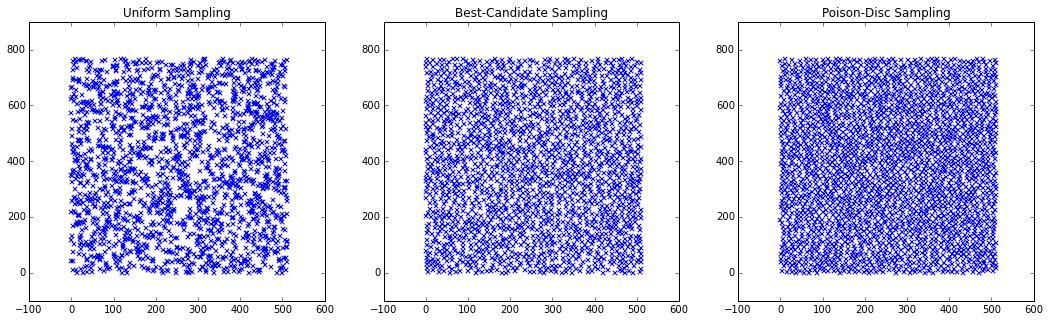

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))
axs[0].scatter(samples_uni[:,0], samples_uni[:,1], marker='x')
axs[0].set_title('Uniform Sampling')
axs[1].scatter(samples_bc[:,0], samples_bc[:,1], marker='x')
axs[1].set_title('Best-Candidate Sampling')
axs[2].scatter(samples_pd[:,0], samples_pd[:,1], marker='x')
axs[2].set_title('Poison-Disc Sampling')
plt.show()

#### Resample images using random samples

In [10]:
image_uni = resample_image(image, samples_uni)
image_bc = resample_image(image, samples_bc)
image_pd = resample_image(image, samples_pd)

#### Plot images

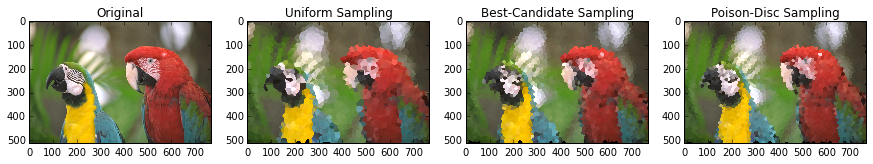

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(15,3))
axs[0].imshow(image)
axs[0].set_title('Original')
axs[1].imshow(image_uni)
axs[1].set_title('Uniform Sampling')
axs[2].imshow(image_bc)
axs[2].set_title('Best-Candidate Sampling')
axs[3].imshow(image_pd)
axs[3].set_title('Poison-Disc Sampling')
plt.show()

### 1d. Implement `distance_map` for colouring image points according to their distance to sample points

The `distance_map` function should generate an image where each pixel intensity is set to the distance to the closest sample point. Hint: You might want to check out the `resample_image` function provided above for guidance.

In [12]:
def distance_map(image, sample_points):
    indices = indices_of_pixels(image)
    c_index, c_distance = closest_index(sample_points, indices)
    h, w, _ = image.shape
    return c_distance.reshape((h, w))

#### Generate distance maps using random samples

In [13]:
distmap_uni = distance_map(image, samples_uni)
distmap_bc  = distance_map(image, samples_bc)
distmap_pd  = distance_map(image, samples_pd)

#### Plot distance maps

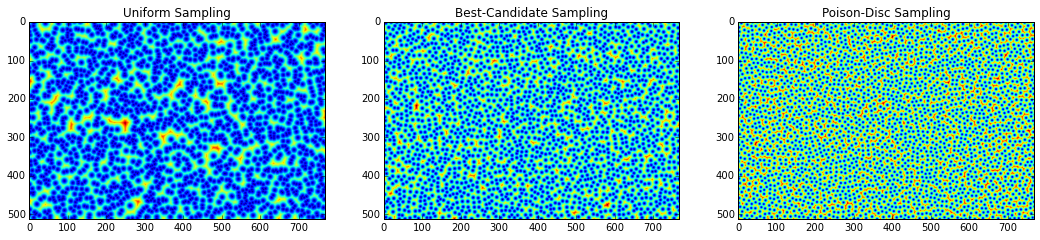

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))
axs[0].imshow(distmap_uni)
axs[0].set_title('Uniform Sampling')
axs[1].imshow(distmap_bc)
axs[1].set_title('Best-Candidate Sampling')
axs[2].imshow(distmap_pd)
axs[2].set_title('Poison-Disc Sampling')
plt.show()